In [1]:
# MIT image
# Made by : HERO Kwon
# Date : 190108

import os
import numpy as np
import pandas as pd
import pickle
import gzip
import matplotlib.pyplot as plt
import math
import cmath

In [2]:
# data path
#path_meta = '/home/herokwon/mount_data/Data/Wi-Fi_meta/'
#path_csi = '/home/herokwon/mount_data/Data/Wi-Fi_processed/'
#path_csi_np = '/home/herokwon/mount_data/Data/Wi-Fi_processed_npy/'

# data path_mi
path_csi = 'D:\\Data\\Wi-Fi_processed\\'
path_csi_np = 'D:\\Data\\Wi-Fi_processed_npy\\'
path_meta = 'D:\\Data\\Wi-Fi_meta\\'

# data info
df_info = pd.read_csv(path_meta+'data_subc_sig_v1.csv')
person_uid = np.unique(df_info['id_person'])
dict_id = dict(zip(person_uid,np.arange(len(person_uid))))
csi_time = 15000 #int(np.max(df_info['len']))
# parameters
max_value = np.max(df_info['max'].values)
#no_classes = len(np.unique(df_info['id_person']))
no_classes = len(dict_id)
csi_subc = 30
input_shape = (csi_time, csi_subc, 6)

In [3]:
# freq BW list
bw_list = pd.read_csv(path_meta+'wifi_f_bw_list.csv')

# avg Array
with open(path_meta + 'dict_avgcsi.pickle','rb') as f:
    dict_avg = pickle.load(f)


# make data generator
def gen_csi(df_info,dict_avg,id_num,len_num):
    for file in np.unique(df_info.id.values):
        # read sample data
        # load and uncompress.
        with gzip.open(path_csi+file+'.pickle.gz','rb') as f:
            data1 = pickle.load(f)
        data1_diff = data1 #np.diff(data1,axis=0)
        # zero pad
        pad_len = len_num - data1_diff.shape[0]
        data1_pad = np.pad(data1_diff,((0,pad_len),(0,0),(0,0),(0,0)),'constant',constant_values=0)

        # Label
        id_key = df_info[df_info.id==file]['id_person'].values[0].astype('int')
        data1_y = dict_id[id_key]
        
        arr_avg = dict_avg[id_key][0]
        data1_result = data1_pad - arr_avg
        
        yield(data1_result ,data1_y,id_key)

gen = gen_csi(df_info,dict_avg,no_classes,csi_time)
target_sig,target_lab,target_id = next(gen)

In [4]:
# 3D scan
m,n = 2,3
c =  299792458 # speed of light 
r = (160 + 160 + 164) * 0.01 # meter
#r = 1.64 #meter
d = 45 * 0.01 # meter
max_ch = 1#3
subc = 14

th_range,si_range = (30,30)
sig_mat = np.zeros([max_ch,csi_time,th_range,si_range])


In [5]:
# 3D calc func
from numba import vectorize
@vectorize(['complex128(complex128,float32,float32,int8,int8,float32,float32,float32,float32,int32,int32)'], target='cpu')
def Recon_3d(sig,theta,sigma,m,n,lam,d,k,r,t,c):
    above_eq1 = 1j * (2*math.pi) * k * r * t / c
    above_eq2 = 1j * (2*math.pi/lam) * math.sin(theta) * ((n+1)*d*math.cos(sigma) + (m+1)*d*math.sin(sigma))
    eq_res = sig * np.exp(above_eq1) * np.exp(above_eq2)
    return eq_res #math.atan2(eq_res.imag,eq_res.real)

In [6]:
def Calc_Above1(k,r,t,c):
    above_eq1 = 1j * (2*math.pi) * k * r * t / c
    return above_eq1

In [7]:
sig1 = target_sig[:,subc,:,:]
sig1[:,0,0].shape

(15000,)

In [8]:
    #for s in range(max_ch):
    s=0
    for i in range(-th_range,th_range):
        for j in range(-si_range,si_range):
            lam =  c*0.000001 / bw_list[str(subc)][8] #wavelength = 300 / frequency in MHz
            t = np.arange(1,csi_time+1,1)
            k = 0.0
            theta = i * (np.radians(360)/2) / th_range
            sigma = j * (np.radians(360)/2) / si_range
            sum_eq = np.zeros(csi_time,dtype=np.complex_)
            for m in range(2):
                for n in range(3):
                    #above_eq1 = Calc_Above1(k,r,t,c)
                    sum_eq += Recon_3d(sig1[:,m,n],theta,sigma,m,n,lam,d,k,r,t,c)
   
            sig_mat[s,:,i,j] =  np.angle(sum_eq)
            #print((s,i,j))

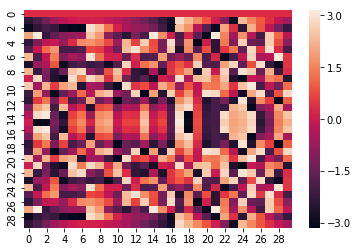

In [11]:
import seaborn as sns
ax = sns.heatmap(sig_mat[0,0,:th_range,:si_range])#,vmin=np.median(sig_mat))

In [ ]:
sig_sum = np.sum(sig_mat,axis=1)
ax = sns.heatmap(sig_sum[0,:th_range,:si_range])#,vmin=np.median(sig_mat))

In [ ]:
np.radians(360)

In [ ]:
2*math.pi

In [ ]:
np.degrees(math.atan(0.5/1.64))*2